## Feedly ML Challenge - Mohamed Bejaoui

The goal of this exercice is to build a binary classifier taking as an input an article and that will tell if it is a tutorial or not.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
from typing import List, Union

import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

### Data import and first look

In [2]:
with open('dataset_tutorials.json') as json_file:
    data = json.load(json_file)

In [3]:
# load articles considered as tutorial into a dataframe
data_tuto = pd.DataFrame.from_records(data['tutorial'])
# add label 1 as a new column to all rows of dataframe
data_tuto.insert(len(data_tuto.columns), 'is_tuto', 1)

# load artiles considered as not tutorial into a dataframe
data_not_tuto = pd.DataFrame.from_records(data['not_tutorial'])
# add label 0 as a new column to all rows of dataframe
data_not_tuto.insert(len(data_not_tuto.columns), 'is_tuto', 0)

data_df = pd.concat([data_tuto, data_not_tuto], ignore_index=True)
data_df.head()

,id,url,date,author,title,text,feed_id,feed_title,is_tuto
0,3G9XVPHWOcFb6mrQlJ/BDQs/pibuUQks9uEZEeRoeT4=_1...,http://www.photoshopstar.com/?p=13425,2016-03-30T07:42:40.033000,Jenny Le,How to Paint a Realistic Tear with Adobe Photo...,In this tutorial I’ll show you how to paint a ...,feed/http://feeds.feedburner.com/photoshopstarcom,Photoshop Star,1
1,s0I3FnXpCtjiZmWsVKz6+g9BEZ4cOtDK6JfrwwYcpfM=_1...,https://design.tutsplus.com/articles/discover-...,2019-12-21T04:00:14.720000,Daisy Ein,Discover Seamless Patterns & Vector Illustrati...,Curious about seamless patterns and vector ill...,feed/http://psd.tutsplus.com/feed/,Envato Tuts+ Design & Illustration,1
2,Y4ZkHntk/bmjO1cBcpT49yuO/MtqgfHqqXUriCsyBL8=_1...,https://www.businessinsider.com/how-to-switch-...,2019-12-11T13:54:12.734000,Marissa Perino,How to switch users on a Mac computer in 3 dif...,You can switch users on a Mac computer in a fe...,feed/http://www.businessinsider.com/latest.rss,Business Insider: The Latest,1
3,s0I3FnXpCtjiZmWsVKz6+g9BEZ4cOtDK6JfrwwYcpfM=_1...,https://design.tutsplus.com/tutorials/quick-ti...,2019-09-23T04:24:06.047000,Jan Stverak,Quick Tip: Create a Glass Text Effect in Photo...,"In this quick tip tutorial, we will show you h...",feed/http://psd.tutsplus.com/feed/,Envato Tuts+ Design & Illustration,1
4,OCDomojt2+FDFvN3Y2j0VoaxdYFePlWFIqHVivtctdY=_1...,https://petapixel.com/2019/09/23/the-7-hardest...,2019-09-23T11:56:16.129000,Michael Zhang,The 7 Hardest Parts of Photography (and How to...,Photographer Nigel Danson recently asked his 5...,feed/http://petapixel.com/topic/tutorials/feed/,Tutorials – PetaPixel,1


In [4]:
print(f"Number of samples: {len(data_df)}")
print(f"Number of attributes: {len(data_df.columns) - 1}")

Number of samples: 658
Number of attributes: 8


We can notice that all the attributes are of type string.<br/>
Let's look for missing values in the dataset

In [5]:
data_df.isnull().sum()

id              0
url             4
date            0
author        248
title           0
text            0
feed_id         0
feed_title      0
is_tuto         0
dtype: int64

Only two attributes contain missing values:
<ul>
    <li>url: 4 missing values</li>
    <li>author: 248 missing values</li>
</ul>

We can use different techniques to fill in these missing values.<br/>
For example, one approach would consist in dropping the rows with missing urls since they are only 4 and do a mode imputation for missing values in author attribute.

### EDA

Let's start by looking at the distribution of the label.

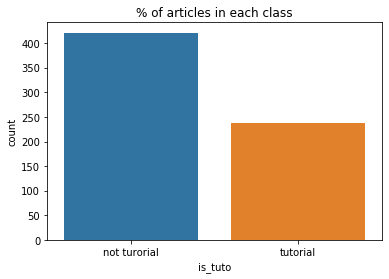

In [6]:
plt.figure()
sns.countplot('is_tuto', data=data_df)
plt.title('% of articles in each class')
plt.xticks(np.arange(2), ('not turorial', 'tutorial'));

In [7]:
print(f"Percentage of articles that are tutorial: {round(100 * len(data_df[data_df.is_tuto == 1]) / len(data_df), 2)}%")
print(f"Percentage of articles that are not tutorial: {round(100 * len(data_df[data_df.is_tuto == 0]) / len(data_df), 2)}%")

Percentage of articles that are tutorial: 36.02%
Percentage of articles that are not tutorial: 63.98%


The classes are not very balanced as the negative class presents approximately 2/3 of the whole dataset.<br/>
To take this into account, I won't depend sololy on the accuracy to measure the models' performances. I will also take into account other metrics, particularly recall and f1 score.

Now, let's see the percentage of unique values for each attribute

In [8]:
print("Number and percentage of unique values:")
for col in data_df.columns[:-1]:
    print(f"{col}: {len(data_df[col].unique())} / {round(100 * len(data_df[col].unique()) / len(data_df), 2)}%")

Number and percentage of unique values:
id: 658 / 100.0%
url: 655 / 99.54%
date: 654 / 99.39%
author: 255 / 38.75%
title: 658 / 100.0%
text: 646 / 98.18%
feed_id: 238 / 36.17%
feed_title: 284 / 43.16%


Two variables of interest we can study are the length of articles and titles. Let's start by vizualising the distribution of these two variables

In [9]:
data_df['text_len'] = data_df.text.str.len()
data_df['title_len'] = data_df.title.str.len()

print('Articles length stats:')
print(data_df.text_len.describe(), '\n')
print('Titles length stats:')
print(data_df.title_len.describe())

Articles length stats:
count      658.000000
mean      4036.787234
std       4419.176110
min          0.000000
25%       1268.000000
50%       2873.000000
75%       5305.000000
max      41848.000000
Name: text_len, dtype: float64 

Titles length stats:
count    658.000000
mean      65.639818
std       24.774958
min       13.000000
25%       50.000000
50%       61.000000
75%       76.000000
max      230.000000
Name: title_len, dtype: float64


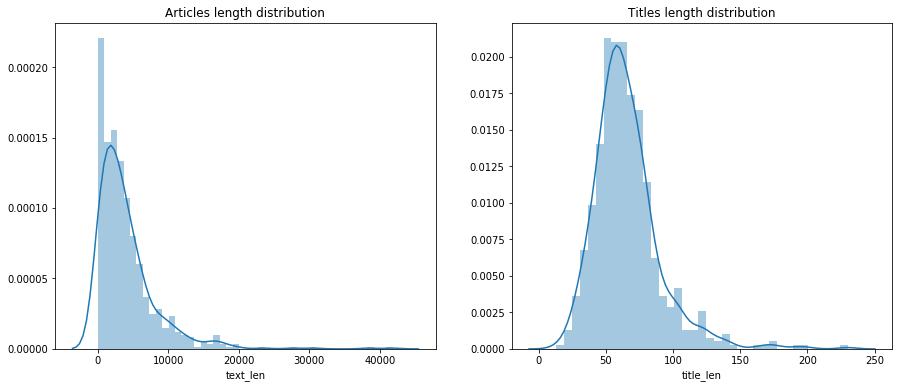

In [10]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.distplot(data_df.text_len).set_title('Articles length distribution');
plt.subplot(1, 2, 2)
sns.distplot(data_df.title_len).set_title('Titles length distribution');

Let's vizualise the distribution of the length of articles and titles across the two classes.

In [11]:
def plot_len_attr_per_class(col_name: str) -> None:
    """ show a boxplot of a column values length per class """
    sns.boxplot(x='is_tuto', y=col_name, data=data_df)
    plt.title(f'{col_name} per class')
    plt.xticks(np.arange(2), ('not turorial', 'tutorial'));

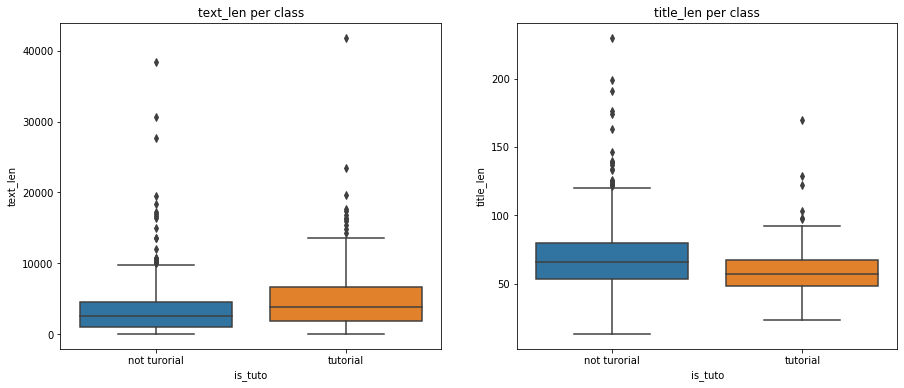

In [12]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plot_len_attr_per_class('text_len')
plt.subplot(1, 2, 2)
plot_len_attr_per_class('title_len')

We can see that tutorial articles tend to be longer and not tutorial titles tend to be shorter but both not in a significant way.<br/><br/>
Another useful thing would be to vizualise the frequency of authors for each class. Let's do that for the 10 most frequent authors per class.

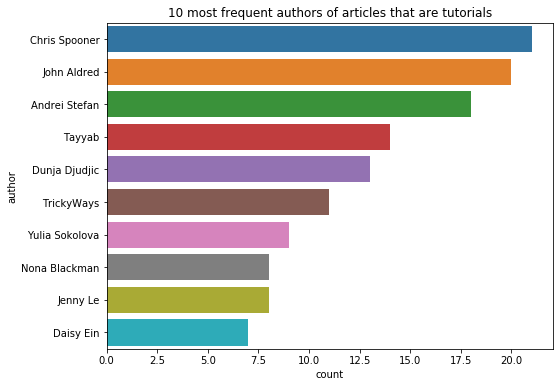

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(y='author', data=data_tuto,
              order=data_tuto.author.value_counts().iloc[:10].index)
plt.title('10 most frequent authors of articles that are tutorials');

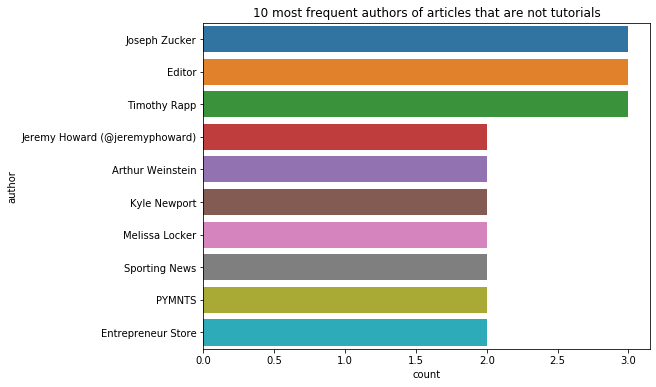

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(y='author', data=data_not_tuto,
              order=data_not_tuto.author.value_counts().iloc[:10].index)
plt.title('10 most frequent authors of articles that are not tutorials');

We can see that none of the most frequent authors of articles that are tutorials write articles that aren't tutorials. This may be considered a proof of the correlation between the attribute author and the class.

It is also interesting to visualize the frequency distribution of the most frequent words in articles for the two classes.

In [20]:
def plot_words_frequencies(col_name: str, label: int, num_words=20, stop_words=False, ngram_range=(1, 1)) -> None:
    """ plot the frequency of the most frequent n_grams in col_name with the given label """
    if stop_words:
        vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    else:
        vec = CountVectorizer(ngram_range=ngram_range)
    vec.fit(data_df[col_name])
    text_vector_tuto = vec.transform(data_tuto[col_name])
    text_vector_not_tuto = vec.transform(data_not_tuto[col_name])

    all_ngrams = vec.get_feature_names()
    num_ngrams = min(20, len(all_ngrams))
    all_counts_tuto = text_vector_tuto.sum(axis=0).tolist()[0]
    all_counts_not_tuto = text_vector_not_tuto.sum(axis=0).tolist()[0]

    all_ngrams, all_counts_not_tuto, all_counts_tuto = zip(*[(n, c_not_tuto, c_tuto) for c_not_tuto, c_tuto, n in \
                                        sorted(zip(all_counts_not_tuto, all_counts_tuto, all_ngrams), 
                                               key= lambda x: x[label], reverse=True)])

    ngrams = all_ngrams[:num_ngrams]
    counts_tuto = all_counts_tuto[:num_ngrams]
    counts_not_tuto = all_counts_not_tuto[:num_ngrams]

    idx = np.arange(num_ngrams)

    plt.figure(figsize=(15, 6))
    plt.bar(idx, counts_tuto, label='tutorial')
    plt.bar(idx, counts_not_tuto, label='not_tutorial')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    label_to_class = {0: 'not_tutorial', 1: 'tutorial'}
    plt.title(f'attribute {col_name} - Frequency distribution of n-grams for class {label_to_class[label]}')
    plt.xticks(idx, ngrams, rotation=45)
    plt.legend()
    plt.show()

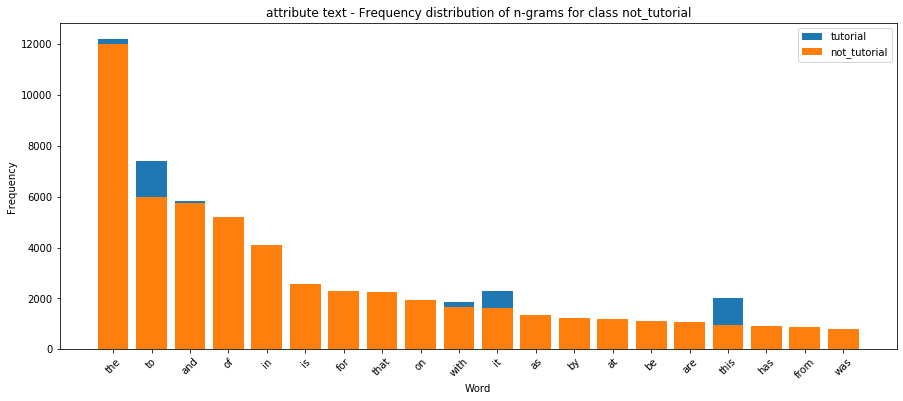

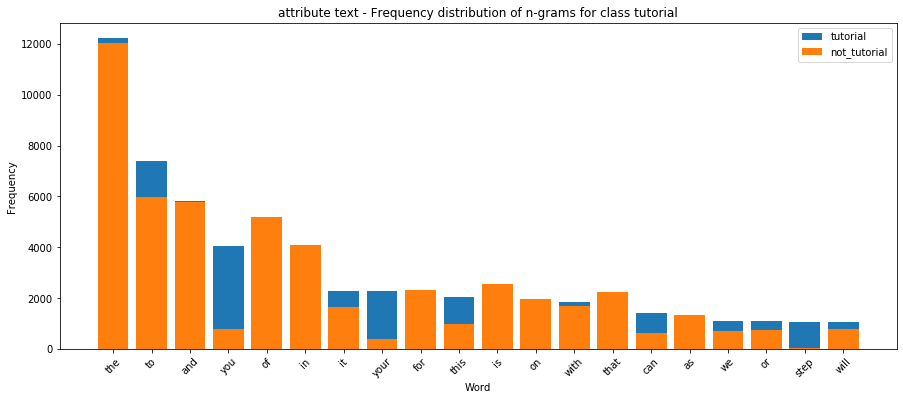

In [21]:
plot_words_frequencies('text', label=0)
plot_words_frequencies('text', label=1)

We can see that the majority of frequent words for both classes are stop words. Let's remove them and plot the same figures again.

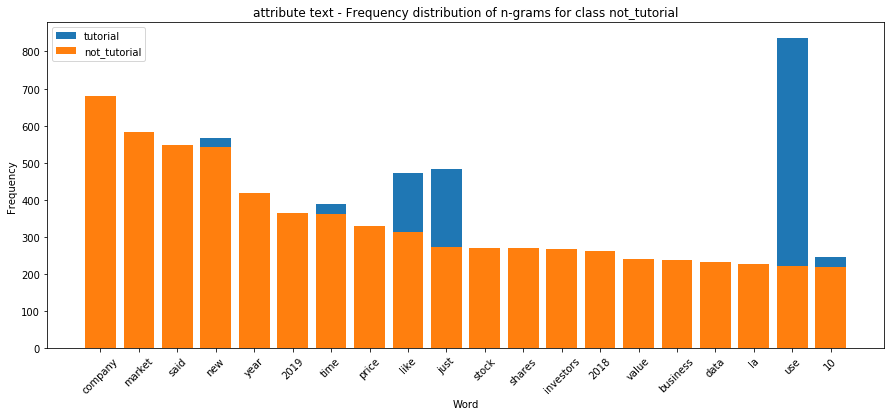

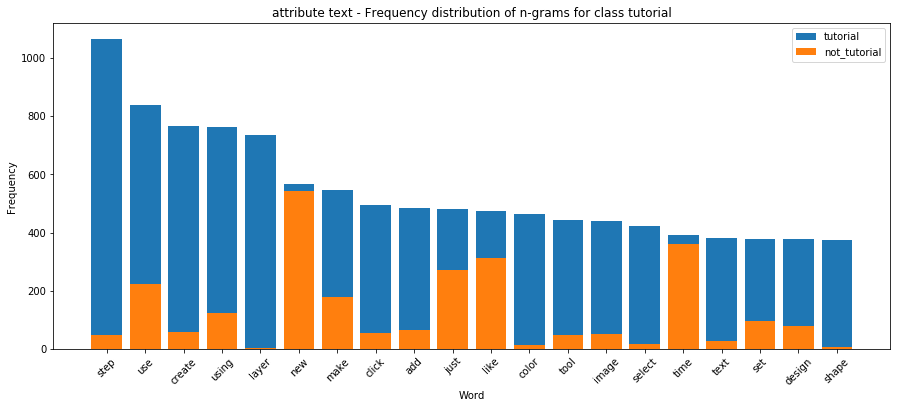

In [22]:
plot_words_frequencies('text', label=0, stop_words=True)
plot_words_frequencies('text', label=1, stop_words=True)

We can see that the words used in a tutorial article are very different from words used in a not-turorial article.<br/>
Now, let's vizualise the same plots but for 2-grams.

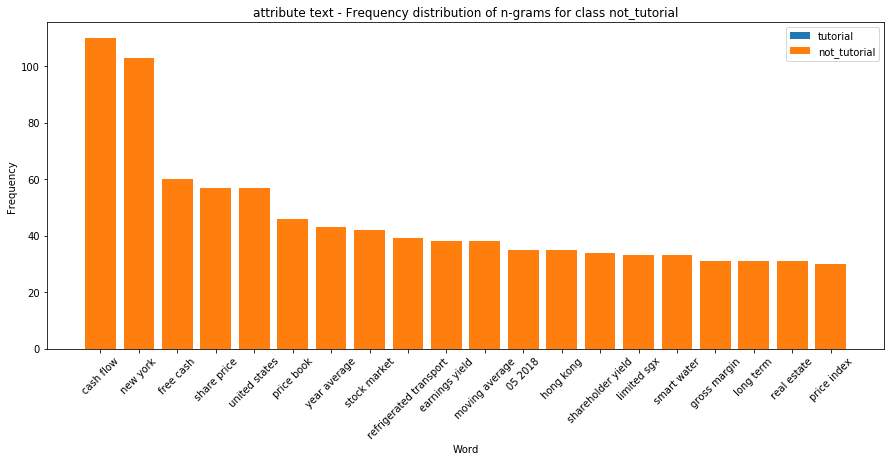

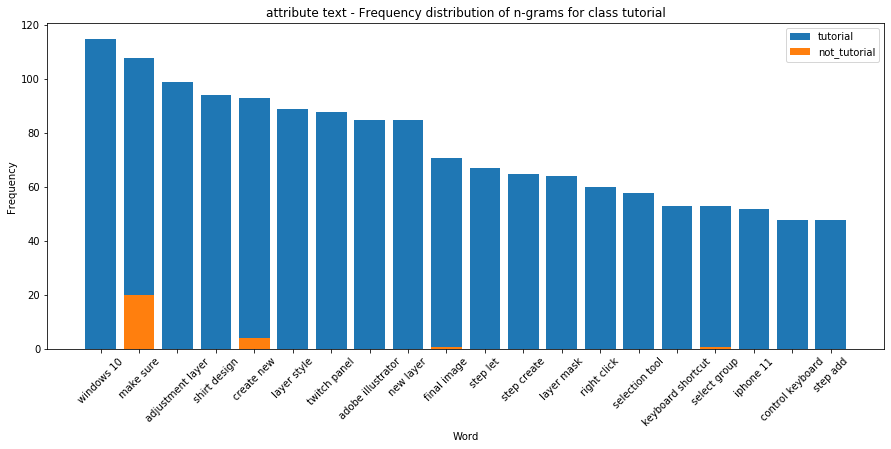

In [23]:
plot_words_frequencies('text', label=0, ngram_range=(2, 2), stop_words=True)
plot_words_frequencies('text', label=1, ngram_range=(2, 2), stop_words=True)

We can see that 2-grams matter. We can see this in 'Windows 10' or 'right click' which would have a different meaning if separated.

We can also vizualise 1-grams for the title attribute.

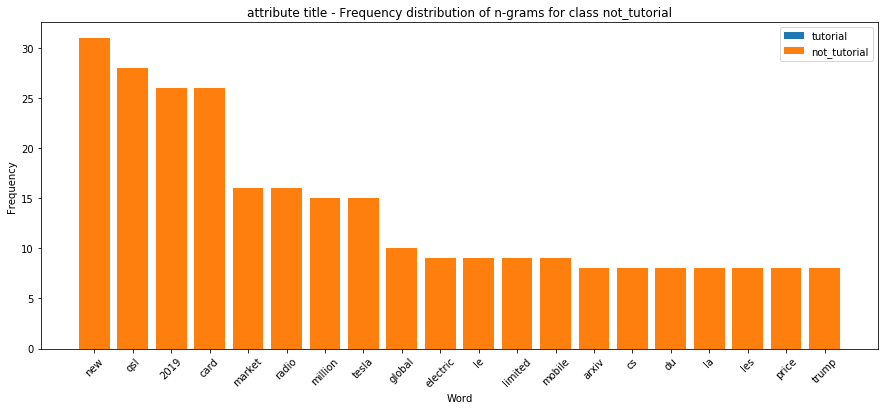

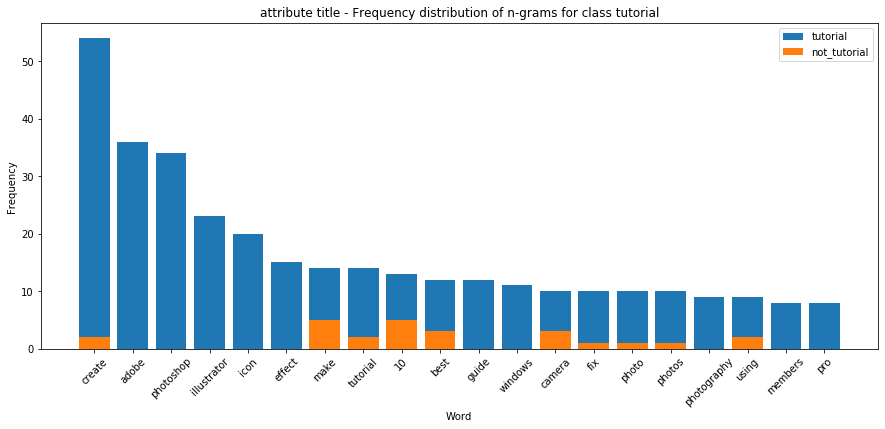

In [24]:
plot_words_frequencies('title', label=0, stop_words=True)
plot_words_frequencies('title', label=1, stop_words=True)

We can see that the frequent words in the title attribute for both classes are different from the text attribute.<br/>
So, it would be interesting to use both of them for the classification task.

### Feature Engineering

First of all, we can see that the id attribute is a unique identifier of a certain article which values don't hold any meaning. This attribute will certainly not contribute to the performance of a classifier. Thus, I will discard it.<br/>
Also, the url attribute can be useful but I chose not to include it in the classification because it may need additional text preprocessing to remove words and characters specific to urls (eg: .com or page numbers) that if left, could add noise to the prediction instead of improving it.<br/>
I won't use feed_id attribute in this exercice for the same reason.<br/>
Besides, I don't see how the date attribute can contribute to the classification especially if it almost has as many unique values as the total number of articles. Thus, I won't work with it neither.<br/>
For simplicity sake, I will also not going to include the feed_title attribute.<br/>
The more we can limit the number of features used the better because we don't have many samples in the dataset.<br/>

Most of the attributes coule be useful for the classification task. We just need to experiment with them and it is time consuming. That's why, I decided to work only with the **text** and **title** attributes and leave the rest in the to go further section.<br/>

Now, I will start by spliting the dataset into a training dataset and a test dataset. I will use the test dataset to measure the performance of the chosen model on unseen samples of articles.

In [124]:
x_train, x_test, y_train, y_test = train_test_split(data_df.drop('is_tuto', axis=1), 
                                                    data_df['is_tuto'],
                                                    test_size=0.1,
                                                    random_state=10)
print(f"Number of train samples: {len(x_train)}")
print(f"Number of test samples: {len(x_test)}")

Number of train samples: 592
Number of test samples: 66


The most important attribute in the dataset is text as it represents the article itself and thus contains all the necessary words related to a certain class.<br/>
Let's start by visualizing a sample text.

In [75]:
x_train.loc[1]['text']

'Curious about seamless patterns and vector illustration? They\'re popular for a reason, and have been for quite some time—they can be very versatile and eye-catching. \nSeamless patterns have a variety of potential applications, from websites to fabric, from packaging to mobile apps. Next time you wrap up a present, take a look at the paper; chances are, it\'s using a seamless pattern. \nEver been curious about how they\'re made, and the vector illustrations that are often a part of their creation? In this article, we\'ll observe the work of Lidia Snitsar, who often shares her work under the studio name Lidiebug. She has ten years of admirable experience and an inspiring portfolio of fun, whimsical art and design—so she\'s a great example to observe and listen in on. \nThere\'s a certain sensitivity and refinement to a really well-made seamless pattern. Take a look! \nSee, that\'s something special about awesome seamless patterns, in my opinion. It\'s more than just repeating a memora

We can see many special characters that need to be cleaned as they don't have any predicting power. Otherwise, they may introduce distortions to the models 

**Text cleaning and preprocessing**

In [27]:
# Download punkt and wordnet
nltk.download('punkt');
nltk.download('wordnet');

[nltk_data] Downloading package punkt to /home/mohamed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mohamed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
# Download the stop words list
nltk.download('stopwords')
# Load the stop words in english
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mohamed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
wordnet_lemmatizer = WordNetLemmatizer()

In [30]:
def preprocess_text(text: str, use_stop_words=True) -> str:
    """ remove unwanted characters from text and lemmatize it """
    # remove line breaks
    text = text.replace('\n', '')
    # remove quotes
    text = text.replace('"', '')
    #lowercase text
    text = text.lower()
    #remove punctuation and special characters ?:!.,[]();
    text = text.translate(str.maketrans('', '', '?:!.,;[]()'))
    # remove possessive pronouns termination
    text = text.replace("'s", "")
    
    # use wordnet lemmatizer on text
    text = ' '.join([wordnet_lemmatizer.lemmatize(word, pos="v") for word in text.split(' ')])
    
    # remove stop words
    if use_stop_words:
        for stop_word in stop_words:
            text.replace(r"\b" + stop_word + r"\b", '')
    
    return text

In [31]:
def select_df_cols(df:pd.DataFrame, cols:List[str]) -> Union[pd.DataFrame, pd.Series]:
    """ return the dataframe with only the given columns """
    if len(cols) == 1:
        return df[cols[0]]
    return df[cols]

def preprocess_text_cols(df:Union[pd.DataFrame, pd.Series]) -> Union[pd.DataFrame, pd.Series]:
    """ preprocess text of every row """
    if isinstance(df, pd.Series):
        return df.apply(preprocess_text)
    return df.applymap(preprocess_text)

We can define the successive transformations of the features engineering process in a pipeline as follows:

In [125]:
vectorizer = FeatureUnion([
    ('text_pipe', make_pipeline(
        FunctionTransformer(select_df_cols, kw_args={'cols': ['text']}),
        FunctionTransformer(preprocess_text_cols),
        TfidfVectorizer(ngram_range=(1, 2), max_features=70, norm='l2', sublinear_tf=True)
    )),
    ('title_pipe', make_pipeline(
        FunctionTransformer(select_df_cols, kw_args={'cols': ['title']}),
        FunctionTransformer(preprocess_text_cols),
        TfidfVectorizer(ngram_range=(1, 2), max_features=30, norm='l2', sublinear_tf=True)
    )),
    
])

I chose a total number of 100 features (70 from text attribute and 30 from title attribute) because if we increase this number, the models will be more prone to overfitting and the performances will decrease.<br/><br/>

Now, let's fit the vectorizer on the train set and transform both the train and test sets into vectors of features ready to be fed into models.

In [126]:
y_train = y_train.values
y_test = y_test.values
x_train = vectorizer.fit_transform(x_train, y_train)
x_test = vectorizer.transform(x_test)

print(f"x_train shape: {x_train.shape}")

x_train shape: (592, 100)


### Predictive Models

I will try the following models:
<ul>
    <li>Logistic Regression</li>
    <li>Support Vector Classifier</li>
    <li>K-Nearest Neighbors</li>
    <li>Random Forest</li>
    <li>XGBoost</li>
</ul>
For models that need hyperparameters tuning, I will define a grid of possible values and perform a grid search using 3-fold cross validation. Then, I will stick with the hyperparameters that gives the best accuracy.

In [86]:
random_state = 42

# dict containing all the models where key is name of model and value is the model itself
models = {}

For Logistic Regression, I decided to go with the default hyperparameters since there aren't significant ones to tune.

In [87]:
models['Logistic Regression'] = LogisticRegression(random_state=random_state)

In [127]:
def perform_grid_search(cls, param_grid):
    """ perform a grid search on a classifier using 3-fold cross validation and the passed prameters """
    grid_search = GridSearchCV(estimator=cls, 
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=3,
                               verbose=1)
    grid_search.fit(x_train, y_train)
    print(f"The best hyperparameters from Grid Seach are: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [128]:
print("SVC:")
param_grid = {
    'C': [.001, .01, .1, 1],
    'gamma': [.0001, .001, .01, .1, 1, 10, 100],
}
cls = SVC(random_state=random_state)
models['SVC'] = perform_grid_search(cls, param_grid)
print('\n')

print("K-NN:")
param_grid = {
    'n_neighbors': [int(x) for x in np.linspace(1, 50, 50)]
}
cls = KNeighborsClassifier()
models['KNN'] = perform_grid_search(cls, param_grid)
print('\n')

print("Random Forest")
# Beforehand, I did a quick randomized seach of 50 iterations in order to get a grasp on the order of magnitute of 
# the hyperparameters
param_grid = {
    'n_estimators': [80, 100, 120],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}
cls = RandomForestClassifier(random_state=random_state)
models['Random Forest'] = perform_grid_search(cls, param_grid)
print('\n')

print("XGBoost")
# Beforehand, I did a quick randomized seach of 50 iterations in order to get a grasp on the order of magnitute of 
# the hyperparameters
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [.01, .1],
    'subsample': [.7, .9, 1],
    'colsample_bytree': [.7, .9, 1],
}
cls = XGBClassifier(random_state=random_state)
models['XGBoost'] = perform_grid_search(cls, param_grid)

SVC:
Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best hyperparameters from Grid Seach are: {'C': 1, 'gamma': 0.1}


K-NN:
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best hyperparameters from Grid Seach are: {'n_neighbors': 13}


Random Forest
Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:   53.0s finished


The best hyperparameters from Grid Seach are: {'class_weight': 'balanced', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


XGBoost
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:   25.2s finished


The best hyperparameters from Grid Seach are: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.9}


Now let's fit the tuned classifiers to the training data

In [129]:
for cls in models.values():
    cls = cls.fit(x_train, y_train)

Now, I will measure the accuracy and f1 score on the train and test datasets for each model and summarize the results in the pandas dataframe.

In [130]:
perf_df = pd.DataFrame(columns=['Classifer', 'Train accuracy', 'Test accuracy', 'Train f1-score', 'Test f1-score'])
for model_name, cls in models.items():
    perf_df = perf_df.append(pd.Series([model_name, 
                   accuracy_score(y_train, cls.predict(x_train)),
                   accuracy_score(y_test, cls.predict(x_test)),
                   f1_score(y_train, cls.predict(x_train)),
                   f1_score(y_test, cls.predict(x_test))], index=perf_df.columns), ignore_index=True)
perf_df

,Classifer,Train accuracy,Test accuracy,Train f1-score,Test f1-score
0,Logistic Regression,0.935811,0.984848,0.906863,0.981818
1,SVC,0.934122,0.969697,0.904177,0.962963
2,KNN,0.893581,0.909091,0.838875,0.888889
3,Random Forest,0.998311,0.954545,0.997613,0.943396
4,XGBoost,0.998311,0.954545,0.997613,0.943396


XGBoost has the best test accuracy and f1 score which are respectively very close to the train accuracy and f1 score.<br/>
We can consider XGBoost as the best found model for this classification task.

In [131]:
cls_best = models['XGBoost']

As a final step, I will plot the classification report, the confusion matrix and ROC curve of the XGBoost classifier.

In [132]:
print("Classification Report:")
print(classification_report(y_test, cls_best.predict(x_test)))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        39
           1       0.96      0.93      0.94        27

    accuracy                           0.95        66
   macro avg       0.96      0.95      0.95        66
weighted avg       0.95      0.95      0.95        66



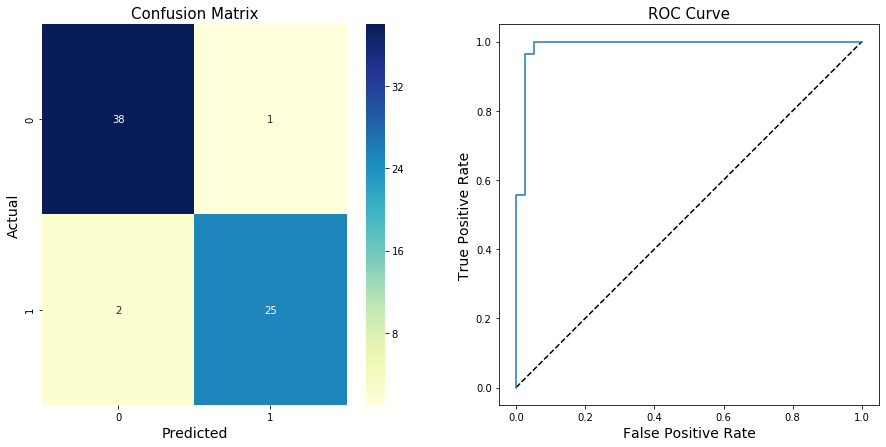


 
 AUC score :  0.9876543209876543


In [133]:
model_test_proba = cls_best.predict_proba(x_test)[:,1]
test_predict = cls_best.predict(x_test)
fpr, tpr, thresholds  = roc_curve(y_test, model_test_proba)


confusion_matrix_test = confusion_matrix(y_test, test_predict)

# Plot confusion matrix
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix_test, annot=True, cmap="YlGnBu")
plt.title("Confusion Matrix", fontsize=15)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)


# Plot ROC curve
plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=15)
plt.show()
print("\n","\n",'AUC score : ', roc_auc_score(y_test, model_test_proba))

The performance is very good. However, this doesn't mean that the model is good and it doesn't garantee that it has a good generalization capacity because the dataset is very small, so the performance depends heavily on how the train and test sets were split. If we change the random_state of the train_test_split function, the performance may worsen.

### Dimensionalty reduction plot

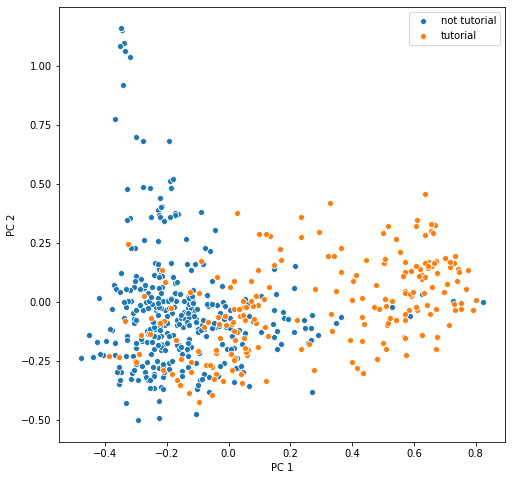

In [134]:
pca = PCA()
x_pca_train = pca.fit_transform(x_train.toarray())

plt.figure(figsize=(8, 8))
classes = ['not tutorial', 'tutorial']
x_pca = [x_pca_train[list(y_train.ravel() == 0)], x_pca_train[list(y_train.ravel() == 1)]]
for i in range(2):
    sns.scatterplot(x_pca[i][:, 0], x_pca[i][:, 1])
plt.legend(classes);
plt.xlabel('PC 1');
plt.ylabel('PC 2');

We can see that a dimensionality reduction technique like PCA can be used to distinguish the two classes.

### To go further

To conclude, I want to mention some ideas that I would test out if I had more time:
<ul>
    <li>spend more time on the hyperparameter tuning to get better performances. For example, this can be done by doing successive grid searches for each model and reducing the range of the parameters in each iteration.</li>
    <li>diagnose the best model. For example, we can analyse the missclassified articles and think about how to improve the performances via new feature engineering tricks.</li>
    <li>spend more time on feature engineering because it is the most important part espacially in a text classification task. For example, we could combine text attribute with title attribute or other attributes, apply Tfidf on the combination and add the steps to the pipeline</li>
    <li>think of ways to deal with the small number of samples versus the need to have more features since we are dealing with text attributes. To do this, for example, we can use the author attribute by transforming it using one-hot encoding, add it to the pipeline and use PCA to shrink the number of features.</li>
    <li>find a better way to split the train and test sets in order to have a more accurate estimation of the real performance of the model</li>
    